In [8]:
import data_prepration
import tf_dataset
import graph_construction
import graph_conv

import pandas as pd
import keras
from keras import layers
from keras import ops
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

In [10]:
from importlib import reload
import graph_construction
reload(graph_construction)


<module 'graph_construction' from '/Users/arminnoqteh/Work/RNN forecast/graph_construction.py'>

In [2]:
plt.rcParams.update(plt.rcParamsDefault)

In [3]:
import os
import pandas as pd

# Specify the folder path
folder_path = 'data/financial/get_volatility_indexes'

# Get a list of all CSV files in the folder
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

merged_df = pd.DataFrame()
for file in csv_files:
    df = pd.read_csv(os.path.join(folder_path, file), names=['date', file.split('.')[0]], index_col='date', parse_dates=True).iloc[1:]
    if merged_df.empty:
        merged_df = df
    else:
        merged_df = pd.merge(merged_df, df, on='date', how='outer')

# just for pragmatic reasons, drop all rows with NaN values
merged_df = merged_df.dropna()


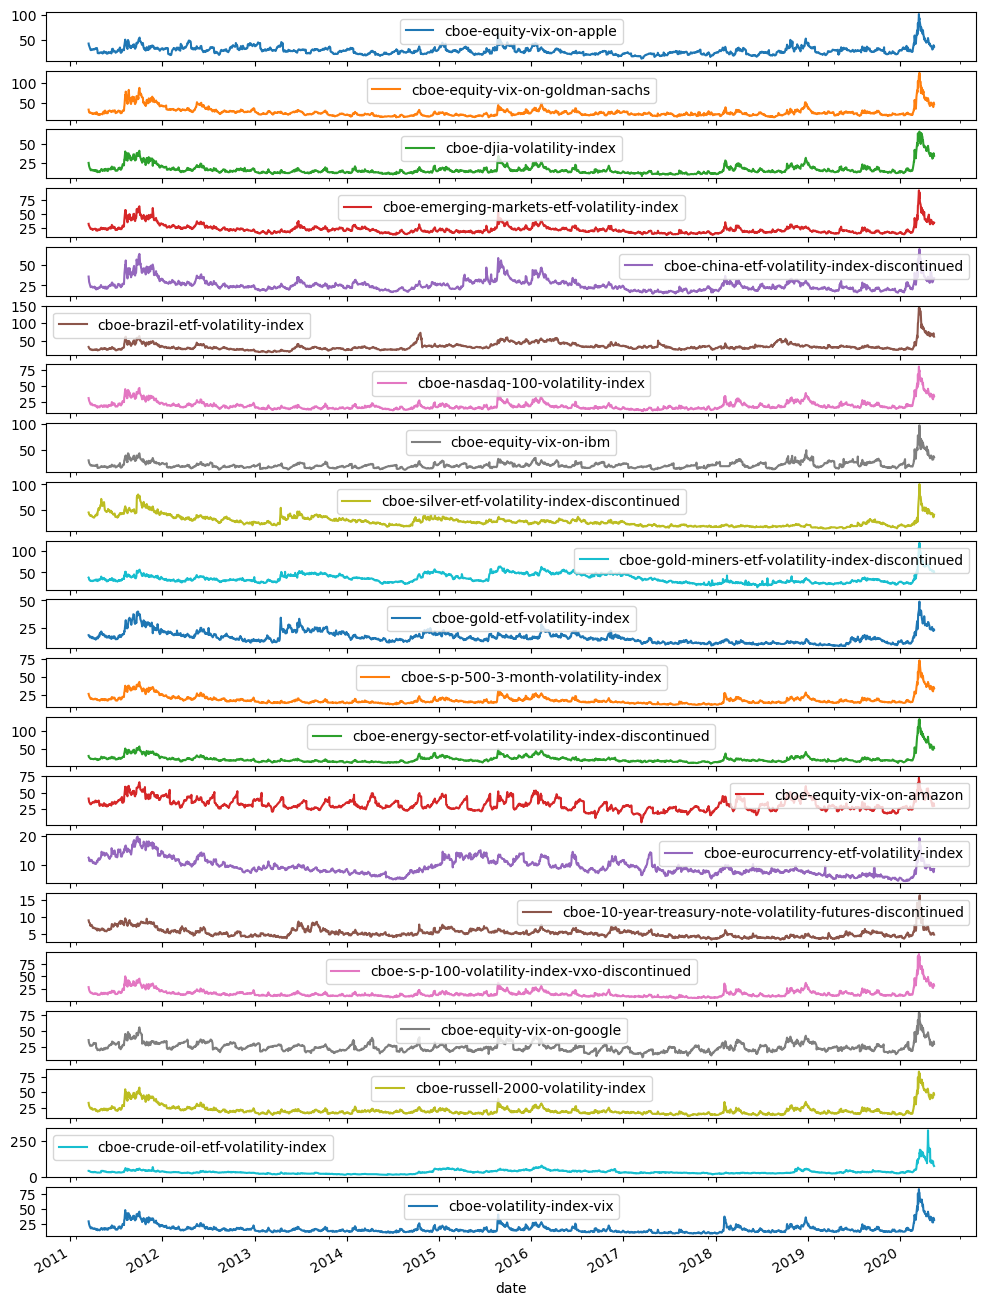

In [38]:
# plot data
merged_df.plot(subplots=True, figsize=(12, 18))
plt.show()

In [4]:
df_array = merged_df.to_numpy()
correlation_matrix = np.corrcoef(df_array, rowvar=False)


In [16]:
# Split the data into train, validation, and test sets
train_size, val_size = 0.6, 0.2
train_array, val_array, test_array = data_prepration.preprocess(df_array, train_size, val_size)
# Define some parameters
num_indicators = merged_df.shape[1] # The number of financial indicators
input_sequence_length = 24 # The length of the input sequence (in number of months)
forecast_horizon = 1 # The forecast horizon (in number of months)
batch_size = 64 # The batch size for the dataset

# Create the tf.data.Dataset objects for the train, validation, and test sets
train_dataset, val_dataset = (
    tf_dataset.create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

test_dataset = tf_dataset.create_tf_dataset(test_array, input_sequence_length, forecast_horizon, batch_size, shuffle=False)

In [17]:
# Create the adjacency matrix and the graph info object
# TODO sigma2 and epsilon should be hyperparameters to be tuned
sigma2 = 0.9
epsilon = 0.5
adjacency_matrix = graph_construction.compute_adjacency_matrix(df_array, sigma2, epsilon)
node_indices, neighbor_indices = adjacency_matrix.nonzero()
graph = graph_construction.GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=num_indicators,
)

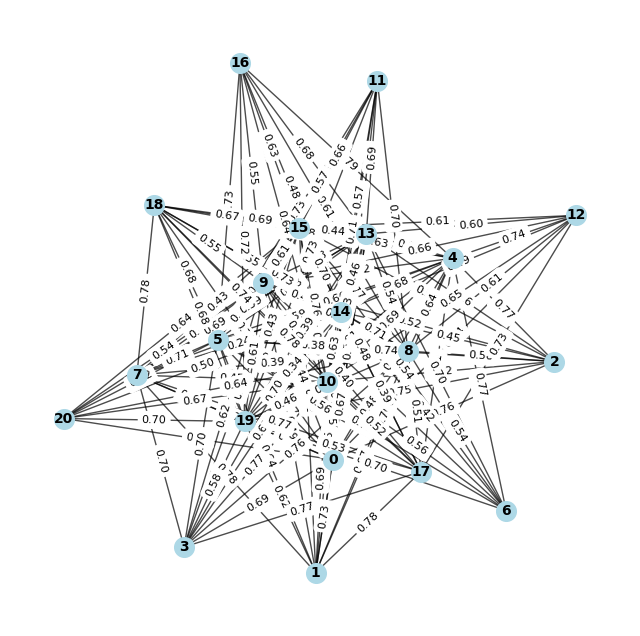

In [18]:
# Plot graph
graph_construction.plot_graph(graph, correlation_matrix)

In [19]:
# training the model
in_feat = 1
epochs = 24
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = graph_conv.LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanSquaredError(),
)
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)
# model's summary
print(model.summary())

Epoch 1/24
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.7279 - val_loss: 0.7302
Epoch 2/24
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.5482 - val_loss: 0.4594
Epoch 3/24
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.3934 - val_loss: 0.2114
Epoch 4/24
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.2891 - val_loss: 0.1346
Epoch 5/24
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.2313 - val_loss: 0.1258
Epoch 6/24
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.2028 - val_loss: 0.1144
Epoch 7/24
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.1798 - val_loss: 0.1039
Epoch 8/24
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.1625 - val_loss: 0.0936
Epoch 9/24
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.1472 - val_loss: 0.0835
Epoch 10/24
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.1339 - val_loss: 0.0792
Epoch 11/24
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.1221 - val_loss: 0.0927
Epoch 12/24
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.1

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 21, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstmgc (LSTMGC)                 │ (None, 1, 21)             │     21,835 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 43,672 (170.60 KB)

 Trainable params: 21,835 (85.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,837 (85.30 KB)

None


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


2024-02-07 22:45:34.405907: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


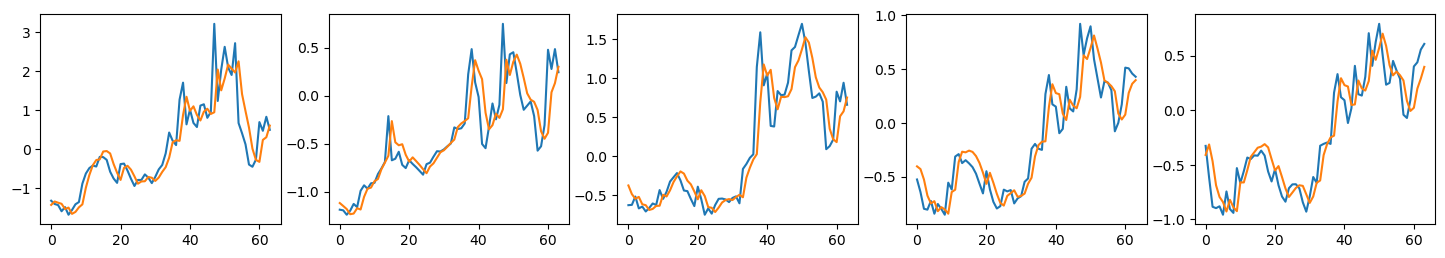

naive MAE: 0.08945218151570943, model MAE: 0.09524494261681982


In [21]:
# test the model for all the columns
x_test, y = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)
plt.figure(figsize=(18, 6))
for j in range(5):
    plt.subplot(2, 5, j + 1)
    plt.plot(y[:, 0, j], label="actual")
    plt.plot(y_pred[:, 0, j], label="forecast")
plt.show()
naive_mse, model_mse = (
    np.square(x_test[:, -1, :, 0] - y[:, 0, :]).mean(),
    np.square(y_pred[:, 0, :] - y[:, 0, :]).mean(),
)
print(f"naive MAE: {naive_mse}, model MAE: {model_mse}")